In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import torch
import sys, os, psutil, gc
import numpy as np, pandas as pd, itertools
import datetime
from tqdm import tqdm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

current_path = rf"{os.getcwd()}"
main_path = os.path.abspath(os.path.dirname(current_path))
sys.path.append(rf"{main_path}")
sys.path.append(rf"{main_path}/src")

import utilities as util
import baysian_ntk_utils as bays_util

torch.cuda.is_available()
os.environ['CASTLE_BACKEND'] = 'pytorch'

# icacls "C:\Users\mulugetawa\.conda\envs\dqm_py38_prod" /grant Everyone:F /t

c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-04 09:13:45,927 - c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-12-04 09:13:46,006 - c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Setup

In [2]:
main_path
DATASET = "EasyVista"
fig_dirpath = rf"{main_path}/results/"
datafilename = f"{DATASET}/causal_data/"
# datafilename = "dummy_causal_data"
util.Path(rf"{fig_dirpath}/{datafilename}").mkdir(exist_ok=True, parents=True)
data_affix = ""
data_sample_tag = "idx"

tObj = util.ProcTimer()
sns.set()
sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 1.})

def set_binary_ax_lims(ax):
    for ax_sub in ax:
     _ = ax_sub.set_yticks([0, 1])

'c:\\Users\\mulugetawa\\OneDrive - Universitetet i Agder\\CERN\\InductionProject\\AnomalyCD'

### Load Binary Data

In [3]:
df_aml_rca = util.load_csv(f"{datafilename}{DATASET}_od_binary_anomaly_flag_data.csv", filepath=fig_dirpath, index_col=0)
df_aml_rca.head()
df_aml_rca.shape

,LMB,ESB,PMDB,CMB,MDB,MB,GSIB,RTMB
t,,,,,,,,
45683,0,0,0,0,0,0,0,0
45684,0,0,0,0,0,0,0,0
45685,0,0,0,0,0,0,0,0
45686,0,0,0,0,0,0,0,0
45687,0,0,0,0,0,0,0,0


(4318, 8)

#### Plot Sparse Data Compression 

In [4]:
ts_plot_kwargs = dict(figsize=(6, 2), ncol_force=True, ncol=4, x_gridno=5, 
                            color="red", xlabel="t index", ylabel="value",
                            wspace=0.1,
                            hspace=0.3,
                            fontsize=24,
                            legendfontsize=20,
                            labelfontsize=24,
                            tickfontsize=24,
                            # bbox_to_anchor=(0.12, 0.99)
                            # bbox_to_anchor=(0., 1.12),
                            iscolor_per_col=False,
                            use_timestamp=False, 
                            isreset_index=False,
                            isshow=False
                            )

saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//EasyVista/causal_data/EasyVista_od_flag.jpg


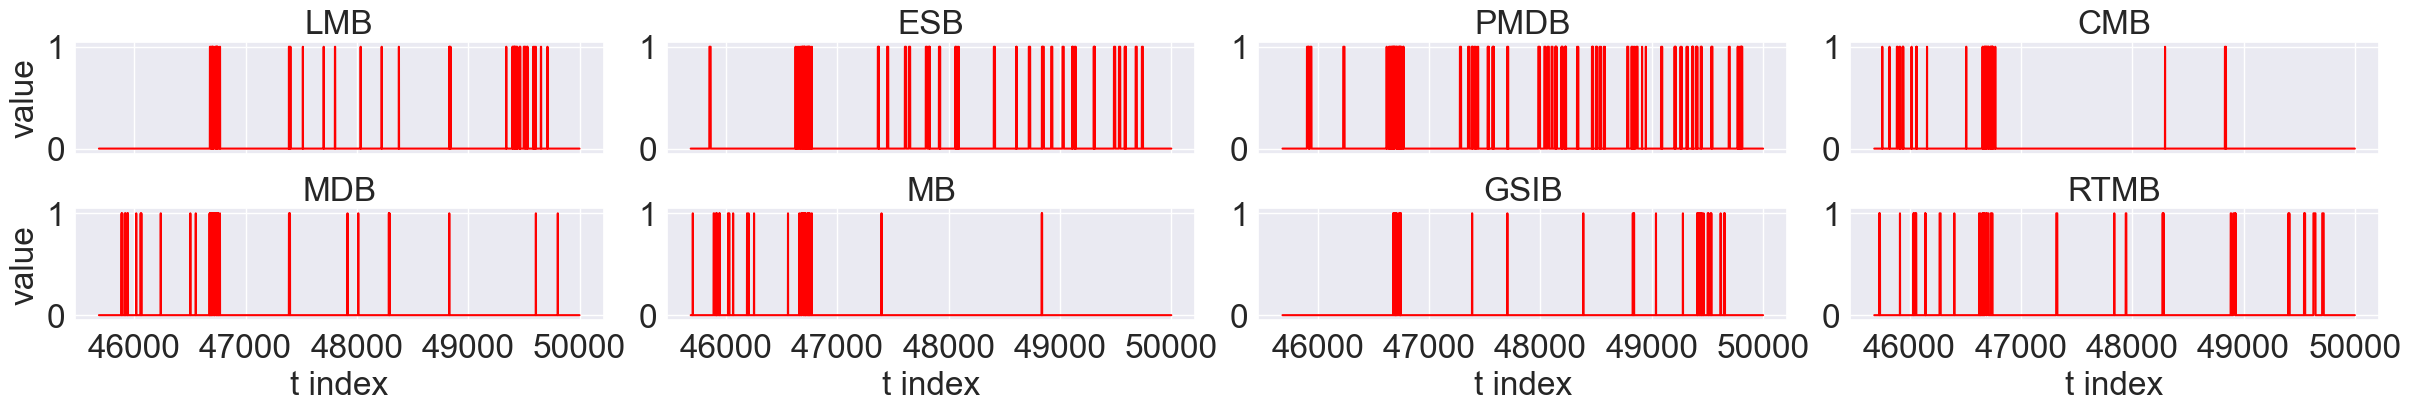

In [5]:
col = 4
fig, ax = util.plot_grid(df_aml_rca, **ts_plot_kwargs)
for i, ax_sub in enumerate(ax):
    _ = ax_sub.set_yticks([0, 1])
    _ = ax_sub.tick_params(axis='y', which='major', pad=1)
    # _ = plt.tillable_format(axis='x', style='sci', scilimits=(2,2), useMathText=True)
    if i >= df_aml_rca.shape[1]-col:
        _ = ax_sub.set_xlabel("t index")

util.save_figure(f"{datafilename}{DATASET}_od_flag", fig,
                 filepath=fig_dirpath, isshow=True, issave=True, dpi=100)

saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//EasyVista/causal_data/EasyVista_cd_sparse_raw_compress_marked.jpg


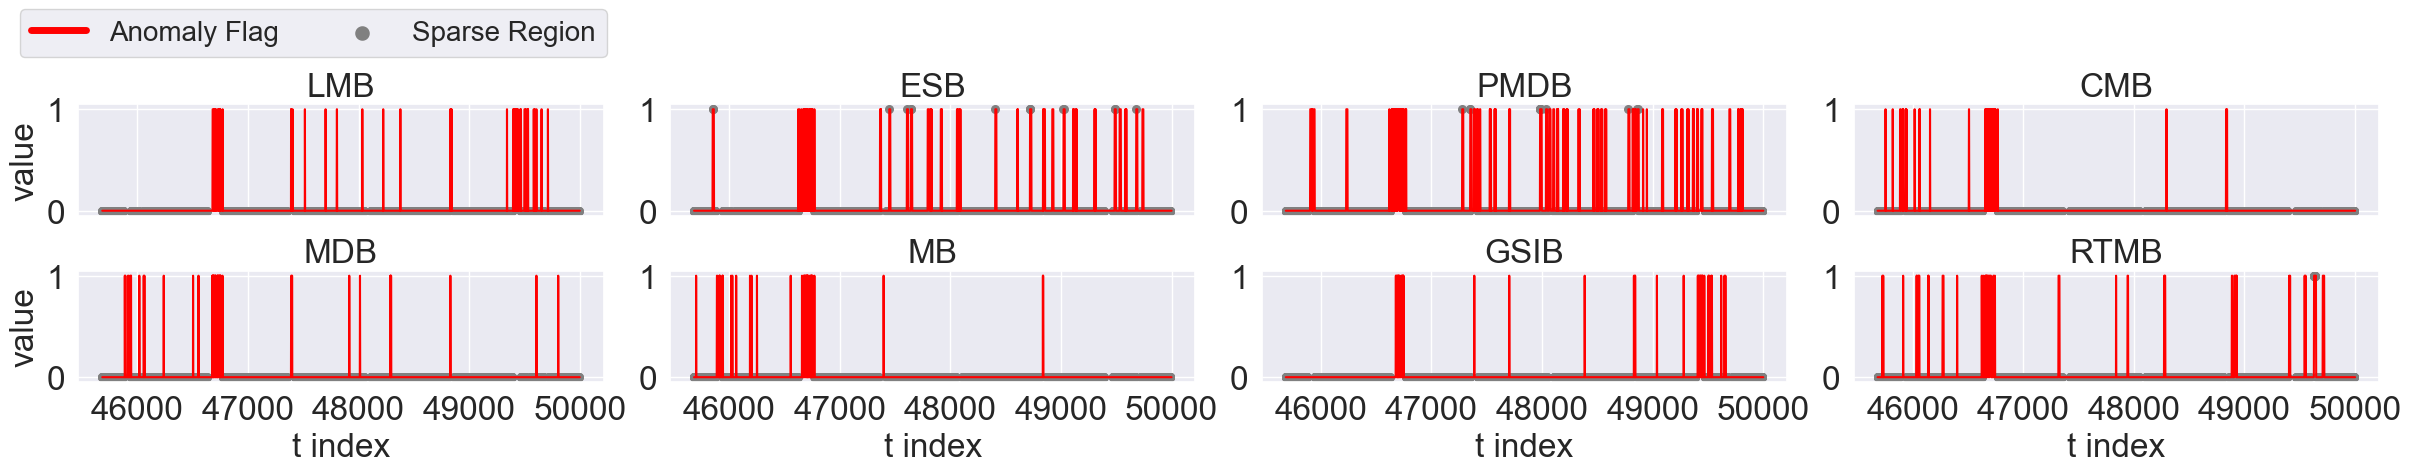

In [6]:
tau_max_ = 5
#  Binary time series plot config
fig = bays_util.sparse_data_highlighter(df_aml_rca.copy(), tau_max=2*tau_max_, **ts_plot_kwargs,
                                        bbox_to_anchor=(0., 1.18))
# _ = plt.ticklabel_format(axis='x', style='sci', scilimits=(2,3), useMathText=True)
util.save_figure(f"{datafilename}{DATASET}_cd_sparse_raw_compress_marked", fig,
                    filepath=fig_dirpath, isshow=True, issave=True, dpi=200)

sparse_data_handler...data_mode: flag:  {'keep_len': 10}
Input data size: (4318, 8), new size: (1938, 8). The rate of compression by 55.12%
saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//EasyVista/causal_data/EasyVista_od_sparse_compressed.jpg


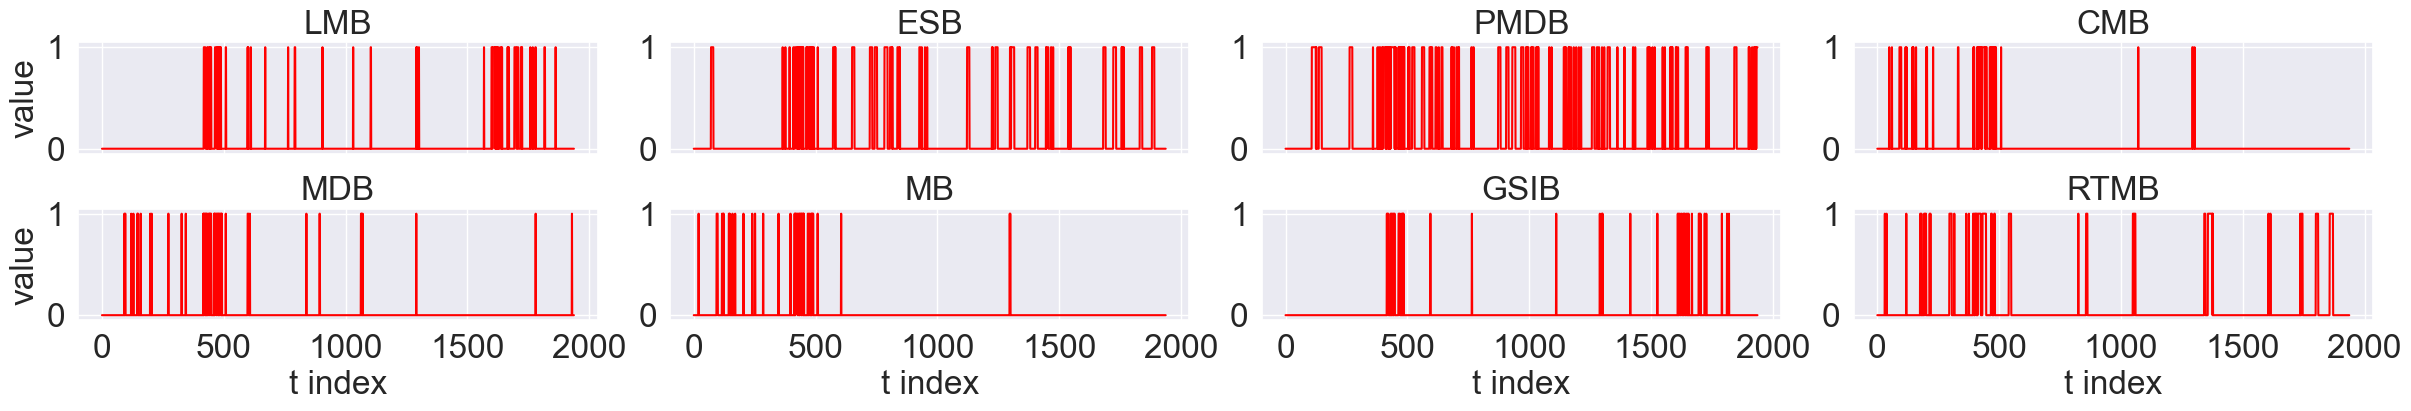

In [7]:
tau_max_ = 5
df_aml_compressed = bays_util.sparse_data_handler(
                                    df_aml_rca.copy(), data_mode="flag", keep_len=2*tau_max_)  # prob changes with for non-ts due to keep_len
                             
fig, ax = util.plot_grid(df_aml_compressed, **ts_plot_kwargs)
for ax_sub in ax:
    _ = ax_sub.set_yticks([0, 1])
util.save_figure(f"{datafilename}{DATASET}_od_sparse_compressed", fig,
                    filepath=fig_dirpath, isshow=True, issave=True, dpi=200)

# Correlation Analysis, with $\tau_{max}=5$ and Compression Data ${l_m={5}}$

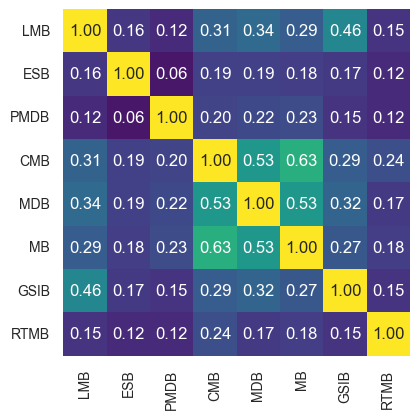

In [9]:
def get_corr_score(df):
    _corr_matrix = df.astype("float64").corr().astype("float64")
    _corr_matrix = _corr_matrix.applymap(lambda x: 0.0 if x < 0 else np.round(x, 2))
    # _corr_matrix
    varnames = df.columns
    vmin = 0.0
    vmax = 1.0
    fmt = "0.2f"
    iscbar = False
    fontsize = 10
    plt.figure(figsize=(4.5,4.5))
    with sns.axes_style("white"):
        ax = sns.heatmap(_corr_matrix.values, vmin=vmin, vmax=vmax, 
                            square=True,
                            annot=True, fmt=fmt, 
                            # cbar_kws=cbar_kws, 
                            cbar=iscbar, 
                            cmap='viridis',
                            ax=None
                        ) 
        _ = ax.set_xticklabels(varnames, rotation=90, fontsize=fontsize)
        _ = ax.set_yticklabels(varnames, rotation=0, fontsize=fontsize)

        plt.show()
    return _corr_matrix

_corr_matrix = get_corr_score(df_aml_rca)

sparse_data_handler...data_mode: flag:  {'keep_len': 5}
Input data size: (4318, 8), new size: (1348, 8). The rate of compression by 68.78%


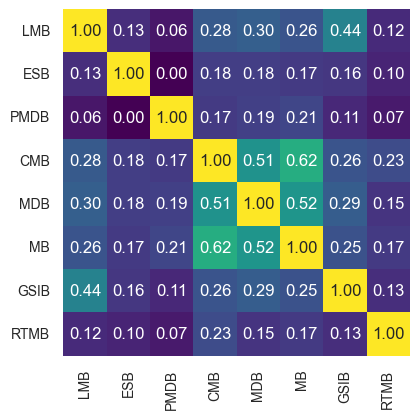

sparse_data_handler...data_mode: flag:  {'keep_len': 10}
Input data size: (4318, 8), new size: (1938, 8). The rate of compression by 55.12%


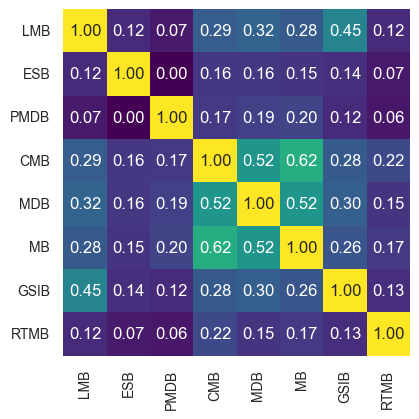

In [10]:
# data compression affects the correlation
for keep_len in range(5, 11, 5):
    _df_aml_compressed = bays_util.sparse_data_handler(
                                    df_aml_rca.copy().fillna(0), data_mode="flag", keep_len=keep_len) 
    _corr_matrix = get_corr_score(_df_aml_compressed)

# CD: Causal Graph Network Learning

In [4]:
from anomaly_cd import AnomalyCD
import networkx as nx
objAnmCD = AnomalyCD()

### Prepare Reference GCM

OutEdgeView([('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'CMB'), ('MDB', 'RTMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')])

Adjacent matrix flat: (8, 8), reshaped: (8, 8, 1)
Index(['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB'], dtype='object')


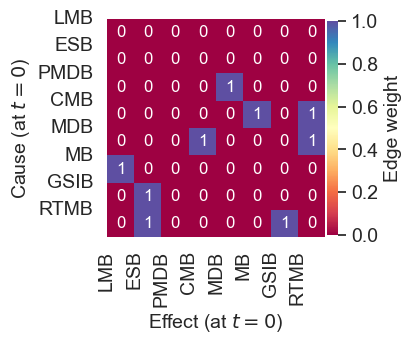

''

plot_dag_graph_ntk...
  source target  weight  t
0   PMDB    MDB       1  0
1    CMB   RTMB       1  0
2    CMB     MB       1  0
3    MDB    CMB       1  0
4    MDB   RTMB       1  0
c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//EasyVista/causal_data/easycd_graph_idx_.html


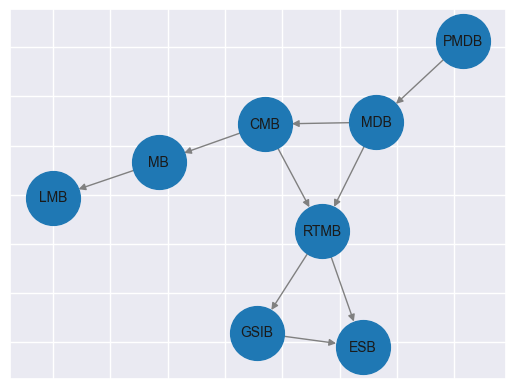

In [5]:
edges_ground_truth = [("PMDB", "MDB"),
                        ("MDB", "CMB"),
                        ("MDB", "RTMB"),
                        ("CMB", "RTMB"),
                        ("CMB", "MB"),
                        ("MB", "LMB"),
                        ("RTMB", "GSIB"),
                        ("RTMB", "ESB"),
                        ("GSIB", "ESB")]

easycd_graph = nx.DiGraph()
easycd_graph.add_nodes_from(df_aml_rca.columns)
easycd_graph.add_edges_from(edges_ground_truth)
easycd_graph.edges()

bays_util.plot_tlagged_weight_map(bays_util.gcm_flat_to_pcmci_result_format(easycd_graph, df_aml_rca.shape[1]), 1, df_aml_rca.columns, 
                                  figsize=(4,4), fmt="0.0f", fontsize=14,
                                  cbar_kws={"label": "Edge weight",
                                                    "shrink":0.6, 
                                                    "orientation": "vertical", "pad": 0.01
                                                 }
                                  )

kwargs = {}
graph_html_filepath = rf"{fig_dirpath}/{datafilename}"
filetag = "_".join([str(v) for v in kwargs.values()])
filetag
graph_theme_sel = "white"
# needs networkx > 3.0?
bays_util.plot_dag_graph_ntk(
    easycd_graph, ntk_structure_alg_tag=f"easycd_graph_{data_sample_tag}_{filetag}", filepath=graph_html_filepath,
    physics=True, label_edges=False,
    height="650px", isshow=True, issave=True, **bays_util.graph_theme[graph_theme_sel]
)

#### GCM for Evaluation

In [6]:
"""
Prepares the reference graph and evaluate the performance of the CD methods
"""

kwargs = {}

easycd_graph.edges()
easycd_graph.nodes

ref_perf = {}
ref_edge_df = pd.DataFrame(easycd_graph.edges(), columns=["src", "dst"])
ref_edge_df["weight"] = 1
ref_edge_df["t"] = 0
ref_edge_df["pval"] = 0
ref_edge_df["src_lag"] = ref_edge_df["src"]

filetag = "_".join([str(v) for v in kwargs.values()])
filetag
graph_theme_sel = "dark"
graph_theme_sel = "white"

ref_perf = {"maxlag": None, "keep_len": None,
            "raw_size": df_aml_rca.shape[0], "compressed_size": None, "proc_t": 0, "edges_df": ref_edge_df}
ref_perf
G = bays_util.prepare_digraph(ref_perf["edges_df"], df_aml_rca.columns.tolist())
G.nodes
# eval check for perfect match
# bays_util.eval_graph_match(G, G)
bays_util.cd_eval_score_extended(G, ref_edge_df, df_aml_rca.columns.tolist(), return_summary=True)

'\nPrepares the reference graph and evaluate the performance of the CD methods\n'

OutEdgeView([('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'CMB'), ('MDB', 'RTMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')])

NodeView(('LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB'))

''

{'maxlag': None,
 'keep_len': None,
 'raw_size': 4318,
 'compressed_size': None,
 'proc_t': 0,
 'edges_df':     src   dst  weight  t  pval src_lag
 0  PMDB   MDB       1  0     0    PMDB
 1   CMB  RTMB       1  0     0     CMB
 2   CMB    MB       1  0     0     CMB
 3   MDB   CMB       1  0     0     MDB
 4   MDB  RTMB       1  0     0     MDB
 5    MB   LMB       1  0     0      MB
 6  GSIB   ESB       1  0     0    GSIB
 7  RTMB  GSIB       1  0     0    RTMB
 8  RTMB   ESB       1  0     0    RTMB}

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')]


NodeView(('LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB'))

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')]
Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')]
predicted edges:  [('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')]
[('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')] [('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB'), ('RTMB', 'GSIB'), ('RTMB', 'ESB')]


{'fpr': 0.0,
 'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'shdu': 0,
 'shd': 0,
 'aprc': 1.0}

### TS

#### PCMCI

##### PCMCI +- ANAC

################################################################################
nonconstant_sensors:  Index(['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB'], dtype='object')
cd_structure_analysis...
build_ts_cd_ntk...
{'filter_menu': False, 'significance_level': 0.05, 'ci_test': 'ParCorr', 'weight_sign': 'both', 'verbosity': 0, 'session': 'easycd_easyvisa', 'isflag_sparse_handle': True, 'session_tag': ''}
tau_max=5, tau_min=0
removeing self_lag links...
blacklist_vars_idx:  []
build_init_link_assumptions...
learn_scm_ts_dag_structure... pcmci {'max_iter': 100, 'link_assumptions': {0: {(1, 0): 'o?o', (1, -1): 'o?>', (1, -2): 'o?>', (1, -3): 'o?>', (1, -4): 'o?>', (1, -5): 'o?>', (2, 0): 'o?o', (2, -1): 'o?>', (2, -2): 'o?>', (2, -3): 'o?>', (2, -4): 'o?>', (2, -5): 'o?>', (3, 0): 'o?o', (3, -1): 'o?>', (3, -2): 'o?>', (3, -3): 'o?>', (3, -4): 'o?>', (3, -5): 'o?>', (4, 0): 'o?o', (4, -1): 'o?>', (4, -2): 'o?>', (4, -3): 'o?>', (4, -4): 'o?>', (4, -5): 'o?>', (5, 0): 'o?o', (5

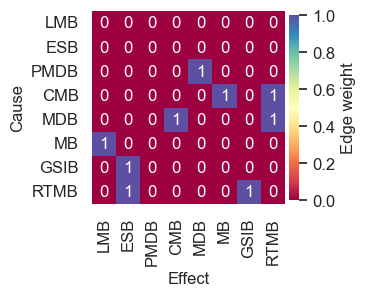

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


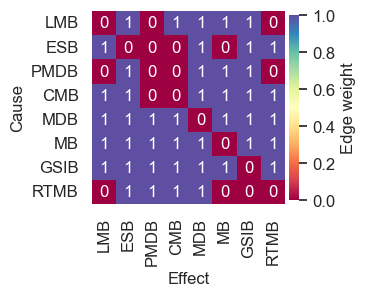

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('LMB', 'ESB'), ('LMB', 'CMB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('ESB', 'RTMB'), ('ESB', 'LMB'), ('PMDB', 'MDB'), ('PMDB', 'GSIB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'ESB'), ('CMB', 'LMB'), ('CMB', 'MDB'), ('CMB', 'GSIB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MDB', 'PMDB'), ('MB', 'GSIB'), ('MB', 'RTMB'), ('MB', 'ESB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'PMDB'), ('MB', 'MDB'), ('GSIB', 'MB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'PMDB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB'), ('RTMB', 'ESB'), ('RTMB', 'CMB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('LMB', 'ESB'), ('LMB', 'CMB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('ESB', 'RTMB'), ('ESB', 'LMB'), ('PMDB', 'MDB'), ('PMDB

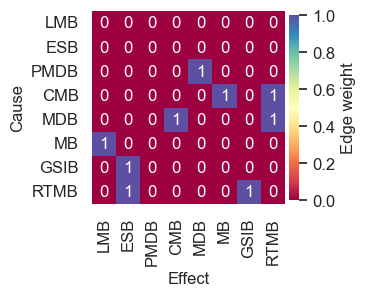

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


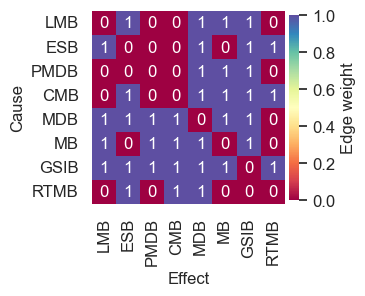

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('LMB', 'ESB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('ESB', 'RTMB'), ('ESB', 'LMB'), ('PMDB', 'MDB'), ('PMDB', 'GSIB'), ('PMDB', 'MB'), ('CMB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'GSIB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MDB', 'PMDB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'PMDB'), ('MB', 'MDB'), ('GSIB', 'MB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'PMDB'), ('GSIB', 'MDB'), ('RTMB', 'MDB'), ('RTMB', 'ESB'), ('RTMB', 'CMB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('LMB', 'ESB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('ESB', 'RTMB'), ('ESB', 'LMB'), ('PMDB', 'MDB'), ('PMDB', 'GSIB'), ('PMDB', 'MB'), ('CMB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'GSIB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB

In [ ]:
# AnomalyCD-Anomaly Transition Aware CI, no sparse handler, ispreprocess_sparse = False

maxlag = 5
keep_len = 2*maxlag
ispreprocess_sparse = False
keep_undirected_at_lagged_zero = False
domain_edges_to_direct = None

gc_algs = {
            'ParCorr': dict(influence_dxn="both"), # non-ANAC
            'ParCorr_ANAC': dict(influence_dxn="positive"), # ANAC
            }
pref_score_gcm_dict = {}
for alg, alg_kwargs in gc_algs.items():
    kwargs = dict(session="easycd_easyvisa",
                    cd_sel="cd_ts",
                    dag_skeleton_alg="pcmci",
                    # influence_dxn="both",
                    ci_test=alg.split("_")[0],
                    significance_level=0.05,
                    maxlag=maxlag,
                    tau_min=0,
                    keep_len=keep_len,
                    ispreprocess_sparse=ispreprocess_sparse, # sparse data enable: nan values
                    isflag_sparse_handle=True, # sparse flags if ispreprocess_sparse is True
                    issparse_link=False, # default is True: self_lag + sparse links
                    isremove_self_lags=True,  # self_lag
                    dag_params_alg=None, session_tag="",
                    )
    df_aml_rca_compressed, dag_skeleton_model, edges_df, net_df, proc_t = AnomalyCD().cd_gcm_build(df_aml_rca.copy(),
                                                                        approach="fullts",
                                                                        verbosity=0,
                                                                        **kwargs, **alg_kwargs)
   
    score_dict = bays_util.cd_eval_score_extended(G, edges_df, df_aml_rca.columns.tolist(), isplot=True)
    score_dict["data_size"] = df_aml_rca_compressed.shape[0]
    score_dict["num_edges"] = edges_df.shape[0]
    score_dict["proc_t_sec"] = proc_t
    pref_score_gcm_dict[alg] = score_dict

In [ ]:
util.print_dict(kwargs)
util.print_dict(pref_score_gcm_dict)
pd.DataFrame.from_dict(pref_score_gcm_dict)  
# add to comparison dfs
pref_score_compare_dfs = []
pref_score_compare_dfs.append(pd.DataFrame.from_dict(pref_score_gcm_dict).add_prefix("RAW__"))


****************************************
session: easycd_easyvisa
cd_sel: cd_ts
dag_skeleton_alg: pcmci
ci_test: ParCorr
significance_level: 0.05
maxlag: 5
tau_min: 0
keep_len: 10
ispreprocess_sparse: False
isflag_sparse_handle: True
issparse_link: False
isremove_self_lags: True
dag_params_alg: None
session_tag: 
****************************************

****************************************
ParCorr: {'fpr': 0.895, 'precision': 0.182, 'recall': 0.889, 'F1': 0.302, 'shdu': 17, 'shd': 37, 'aprc': 0.543, 'data_size': 4318, 'num_edges': 96, 'proc_t_sec': 74.667307138443}
ParCorr_ANAC: {'fpr': 0.684, 'precision': 0.189, 'recall': 0.778, 'F1': 0.304, 'shdu': 13, 'shd': 32, 'aprc': 0.499, 'data_size': 4318, 'num_edges': 54, 'proc_t_sec': 73.36598706245422}
****************************************


,ParCorr,ParCorr_ANAC
fpr,0.895000,0.684000
precision,0.182000,0.189000
recall,0.889000,0.778000
F1,0.302000,0.304000
shdu,17.000000,13.000000
shd,37.000000,32.000000
aprc,0.543000,0.499000
data_size,4318.000000,4318.000000
num_edges,96.000000,54.000000
proc_t_sec,74.667307,73.365987


##### PCMCI +- ANAC + Sparse Data Handler

################################################################################
nonconstant_sensors:  Index(['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB'], dtype='object')
sparse_data_handler...data_mode: nan:  {'method': None, 'fill_value': 0.0, 'isdrop_all_mode': False, 'keep_len': 10, 'isdropna': True, 'issparse_gap_opt': True, 'isfillna': True, 'min_gap_len': 5, 'nan_gap_keep_len': 5}
nan_handler... {'keep_len': 10, 'min_gap_len': 5, 'nan_gap_keep_len': 5}
dropping nan before:  (4318, 8)
num of nan records:  0
sparse_time_gap_handler...
(4318, 8)
nan_gap_keep_len: 5, min_gap_len: 5
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Number of gaps:  0
(4318, 8)
dropping nan after:  (4318, 8)
num of nan records:  0
       LMB  ESB  PMDB  CMB  MDB   MB  GSIB  RTMB
t                                               
45683  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
45684  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
45685  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
45686  

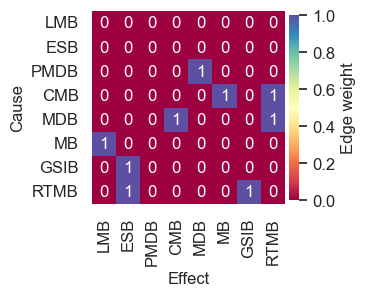

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


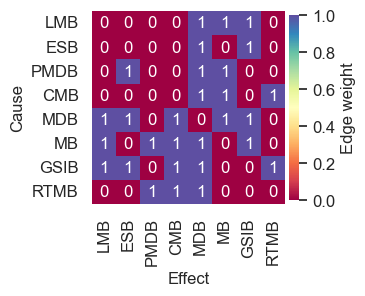

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'PMDB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB'), ('RTMB', 'CMB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'PMDB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MD

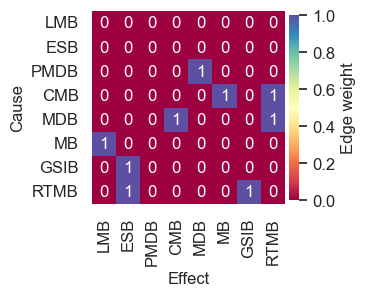

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


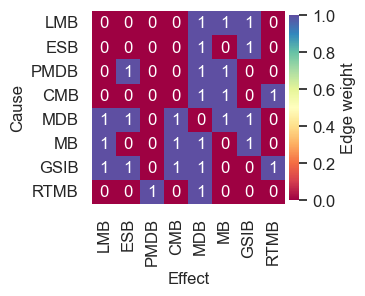

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB')]
[('PMDB',

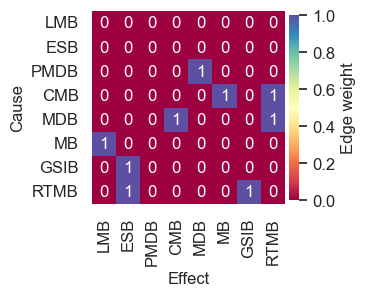

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


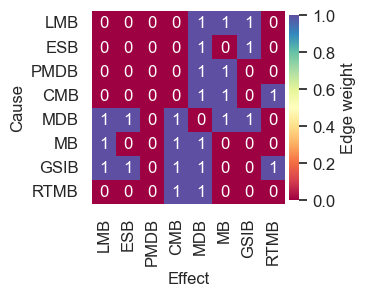

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB'), ('RTMB', 'CMB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB'), ('RTMB', 'CMB')]
[('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'C

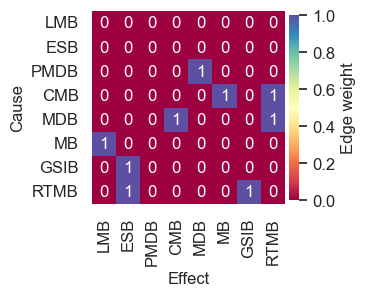

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


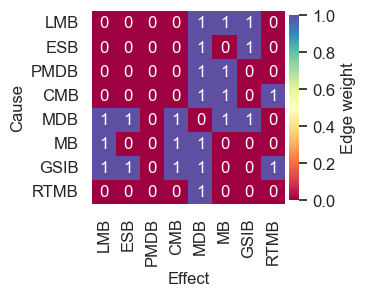

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB')]
[('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB

In [74]:
# AnomalyCD-Anomaly Transition Aware CI, with sparse handler, data: ispreprocess_sparse=True isflag_sparse_handle=True, and issparse_link=False
maxlag = 5
keep_len = 2*maxlag
ispreprocess_sparse = True
keep_undirected_at_lagged_zero = True
domain_edges_to_direct = None
gc_algs = {
            'ParCorr': dict(influence_dxn="both"), # non-ANAC
            'ParCorr_ANAC': dict(influence_dxn="positive"), # ANAC
        }
pref_score_gcm_dict = {}
for alg, alg_kwargs in gc_algs.items():
    kwargs = dict(session="easycd_easyvisa",
                  cd_sel="cd_ts",
                  dag_skeleton_alg="pcmci",
                  ci_test=alg.split("_")[0],
                  significance_level=0.05,
                  maxlag=maxlag,
                  tau_min=0,
                  keep_len=keep_len,
                  ispreprocess_sparse=ispreprocess_sparse,
                  isflag_sparse_handle=True,
                  issparse_link=False,
                  isremove_self_lags=True,
                  dag_params_alg=None, session_tag="",
                  )
    
    df_aml_rca_compressed, dag_skeleton_model, edges_df, net_df, proc_t = AnomalyCD().cd_gcm_build(df_aml_rca.copy(),
                                                                        approach="fullts",
                                                                        verbosity=0,
                                                                        **kwargs, **alg_kwargs)
   
    score_dict = bays_util.cd_eval_score_extended(G, edges_df, df_aml_rca.columns.tolist(), isplot=True)
    score_dict["data_size"] = df_aml_rca_compressed.shape[0]
    score_dict["num_edges"] = edges_df.shape[0]
    score_dict["proc_t_sec"] = proc_t
    pref_score_gcm_dict[alg] = score_dict
    
    # Edge pruning
    prune_opt = {"isweight_first": False,
                    "weight_aware": True,
                    "use_weighted_tlag": True, "verbose": False}
    tObj.restart()
    bn_edges_df = bays_util.prune_binary_ts_edges(edges_df, keep_undirected_at_lagged_zero=keep_undirected_at_lagged_zero,
                                                  domain_edges=domain_edges_to_direct, **prune_opt)
    tObj.stop()
    score_dict = bays_util.cd_eval_score_extended(G, bn_edges_df, df_aml_rca.columns.tolist(), isplot=True)
    score_dict["data_size"] = df_aml_rca_compressed.shape[0]
    score_dict["num_edges"] = bn_edges_df.shape[0]
    score_dict["proc_t_sec"] = proc_t +  tObj.get_proctime()
    pref_score_gcm_dict[f"{alg}_pruned_t_first"] = score_dict
    

In [ ]:
util.print_dict(kwargs)
util.print_dict(pref_score_gcm_dict)
pd.DataFrame.from_dict(pref_score_gcm_dict)
# add to comparison dfs
pref_score_compare_dfs.append(pd.DataFrame.from_dict(pref_score_gcm_dict).add_prefix("SPARSE_DATA_HANDLER__"))


****************************************
session: easycd_easyvisa
cd_sel: cd_ts
dag_skeleton_alg: pcmci
ci_test: ParCorr
significance_level: 0.05
maxlag: 5
tau_min: 0
keep_len: 10
ispreprocess_sparse: True
isflag_sparse_handle: True
issparse_link: False
isremove_self_lags: True
dag_params_alg: None
session_tag: 
****************************************

****************************************
ParCorr: {'fpr': 0.632, 'precision': 0.207, 'recall': 0.667, 'F1': 0.316, 'shdu': 13, 'shd': 26, 'aprc': 0.46, 'data_size': 1938, 'num_edges': 49, 'proc_t_sec': 7.0042407512664795}
ParCorr_pruned_t_first: {'fpr': 0.632, 'precision': 0.222, 'recall': 0.667, 'F1': 0.333, 'shdu': 13, 'shd': 24, 'aprc': 0.468, 'data_size': 1938, 'num_edges': 27, 'proc_t_sec': 7.032155990600586}
ParCorr_ANAC: {'fpr': 0.474, 'precision': 0.24, 'recall': 0.667, 'F1': 0.353, 'shdu': 10, 'shd': 22, 'aprc': 0.477, 'data_size': 1938, 'num_edges': 37, 'proc_t_sec': 6.570874452590942}
ParCorr_ANAC_pruned_t_first: {'fpr': 0.4

,ParCorr,ParCorr_pruned_t_first,ParCorr_ANAC,ParCorr_ANAC_pruned_t_first
fpr,0.632000,0.632000,0.474000,0.474000
precision,0.207000,0.222000,0.240000,0.250000
recall,0.667000,0.667000,0.667000,0.667000
F1,0.316000,0.333000,0.353000,0.364000
shdu,13.000000,13.000000,10.000000,10.000000
shd,26.000000,24.000000,22.000000,21.000000
aprc,0.460000,0.468000,0.477000,0.482000
data_size,1938.000000,1938.000000,1938.000000,1938.000000
num_edges,49.000000,27.000000,37.000000,24.000000
proc_t_sec,7.004241,7.032156,6.570874,6.595818


##### PCMCI +- ANAC +- Edge Pruning + Sparse Data Handler + Sparse Link Handler

################################################################################
nonconstant_sensors:  Index(['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB'], dtype='object')
sparse_data_handler...data_mode: nan:  {'method': None, 'fill_value': 0.0, 'isdrop_all_mode': False, 'keep_len': 10, 'isdropna': True, 'issparse_gap_opt': True, 'isfillna': True, 'min_gap_len': 5, 'nan_gap_keep_len': 5}
nan_handler... {'keep_len': 10, 'min_gap_len': 5, 'nan_gap_keep_len': 5}
dropping nan before:  (4318, 8)
num of nan records:  0
sparse_time_gap_handler...
(4318, 8)
nan_gap_keep_len: 5, min_gap_len: 5
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Number of gaps:  0
(4318, 8)
dropping nan after:  (4318, 8)
num of nan records:  0
       LMB  ESB  PMDB  CMB  MDB   MB  GSIB  RTMB
t                                               
45683  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
45684  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
45685  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
45686  

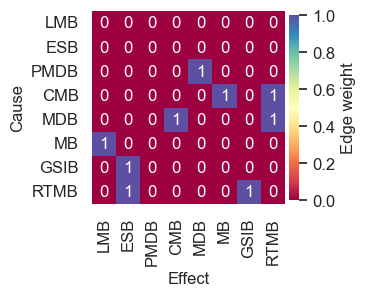

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


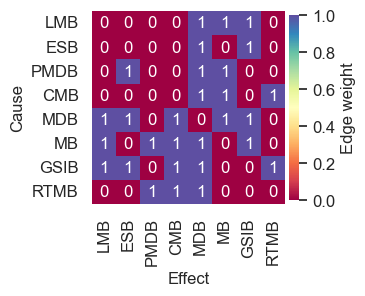

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'PMDB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB'), ('RTMB', 'CMB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'PMDB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MD

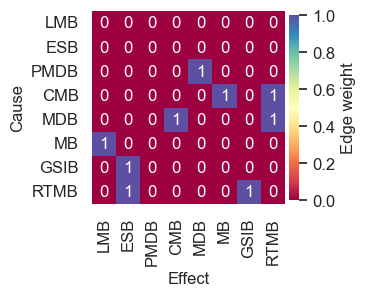

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


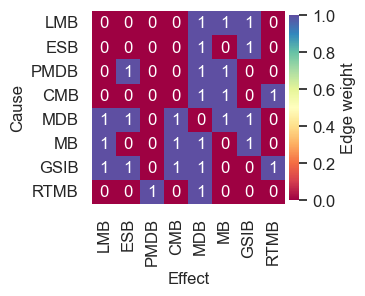

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('PMDB', 'ESB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'GSIB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'PMDB'), ('RTMB', 'MDB')]
[('PMDB',

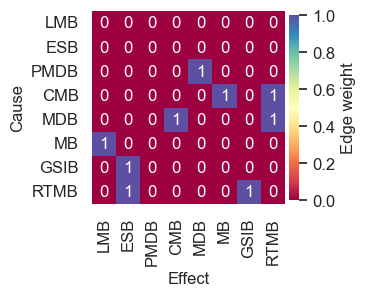

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


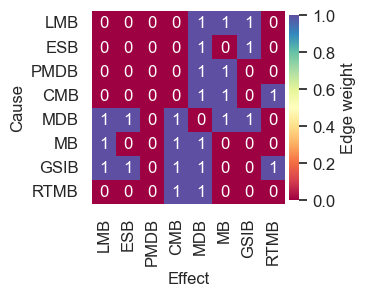

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB'), ('RTMB', 'CMB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB'), ('RTMB', 'CMB')]
[('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'C

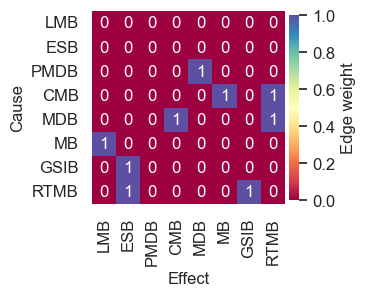

Estimated GCM
['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']


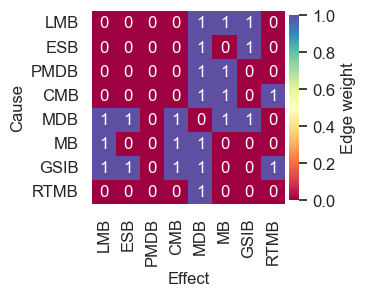

Graph nodes all: ['LMB', 'ESB', 'PMDB', 'CMB', 'MDB', 'MB', 'GSIB', 'RTMB']
Graph edges: [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB')]
predicted edges:  [('LMB', 'MDB'), ('LMB', 'GSIB'), ('LMB', 'MB'), ('ESB', 'MDB'), ('ESB', 'GSIB'), ('PMDB', 'MDB'), ('PMDB', 'MB'), ('CMB', 'MDB'), ('CMB', 'MB'), ('CMB', 'RTMB'), ('MDB', 'GSIB'), ('MDB', 'MB'), ('MDB', 'ESB'), ('MDB', 'LMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('MB', 'CMB'), ('MB', 'MDB'), ('GSIB', 'RTMB'), ('GSIB', 'ESB'), ('GSIB', 'LMB'), ('GSIB', 'CMB'), ('GSIB', 'MDB'), ('RTMB', 'MDB')]
[('PMDB', 'MDB'), ('CMB', 'RTMB'), ('CMB', 'MB'), ('MDB', 'RTMB'), ('MDB', 'CMB'), ('MB', 'LMB'), ('GSIB', 'ESB

In [78]:
# AnomalyCD-Anomaly Transition Aware CI, with sparse handler, data: ispreprocess_sparse=True isflag_sparse_handle=True, and issparse_link=True

maxlag = 5
keep_len = 2*maxlag
ispreprocess_sparse = True
link_assume_thr = 0.10
# link_assume_thr = 0.00
keep_undirected_at_lagged_zero = True
domain_edges_to_direct = None
gc_algs = {
            'ParCorr': dict(influence_dxn="both"), # non-ANAC
            'ParCorr_ANAC': dict(influence_dxn="positive"), # ANAC
            }

pref_score_gcm_dict = {}
for alg, alg_kwargs in gc_algs.items():
    kwargs = dict(session="easycd_easyvisa",
                  cd_sel="cd_ts",
                  dag_skeleton_alg="pcmci",
                  ci_test=alg.split("_")[0],
                  significance_level=0.05,
                  maxlag=maxlag,
                  tau_min=0,
                  keep_len=keep_len,
                  ispreprocess_sparse=ispreprocess_sparse,
                  isflag_sparse_handle=True,
                  issparse_link=True,
                  isremove_self_lags=True,
                  link_assume_thr=link_assume_thr,
                  dag_params_alg=None, session_tag="",
                  )

    df_aml_rca_compressed, dag_skeleton_model, edges_df, net_df, proc_t = AnomalyCD().cd_gcm_build(df_aml_rca.copy(),
                                                                        approach="fullts",
                                                                        verbosity=0,
                                                                        **kwargs, **alg_kwargs)
    # break
    score_dict = bays_util.cd_eval_score_extended(G, edges_df, df_aml_rca.columns.tolist(), isplot=True)
    score_dict["data_size"] = df_aml_rca_compressed.shape[0]
    score_dict["num_edges"] = edges_df.shape[0]
    score_dict["proc_t_sec"] = proc_t
    pref_score_gcm_dict[alg] = score_dict

    # Edge pruning
    prune_opt = {"isweight_first": False,
                    "weight_aware": True,
                    "use_weighted_tlag": True, "verbose": False}
    tObj.restart()
    bn_edges_df = bays_util.prune_binary_ts_edges(edges_df, keep_undirected_at_lagged_zero=keep_undirected_at_lagged_zero,
                                                  domain_edges=domain_edges_to_direct, **prune_opt)
    tObj.stop()
    score_dict = bays_util.cd_eval_score_extended(G, bn_edges_df, df_aml_rca.columns.tolist(), isplot=True)
    score_dict["data_size"] = df_aml_rca_compressed.shape[0]
    score_dict["num_edges"] = bn_edges_df.shape[0]
    score_dict["proc_t_sec"] = proc_t +  tObj.get_proctime()
    pref_score_gcm_dict[f"{alg}_pruned_t_first"] = score_dict
    

In [80]:
util.print_dict(kwargs)
util.print_dict(pref_score_gcm_dict)
pd.DataFrame.from_dict(pref_score_gcm_dict)
# add to comparison dfs
pref_score_compare_dfs.append(pd.DataFrame.from_dict(pref_score_gcm_dict).add_prefix("SPARSE_DATA_AND_LINK_HANDLER__"))


****************************************
session: easycd_easyvisa
cd_sel: cd_ts
dag_skeleton_alg: pcmci
ci_test: ParCorr
significance_level: 0.05
maxlag: 5
tau_min: 0
keep_len: 10
ispreprocess_sparse: True
isflag_sparse_handle: True
issparse_link: True
isremove_self_lags: True
link_assume_thr: 0.1
dag_params_alg: None
session_tag: 
****************************************

****************************************
ParCorr: {'fpr': 0.632, 'precision': 0.207, 'recall': 0.667, 'F1': 0.316, 'shdu': 13, 'shd': 26, 'aprc': 0.46, 'data_size': 1938, 'num_edges': 49, 'proc_t_sec': 6.206700801849365}
ParCorr_pruned_t_first: {'fpr': 0.632, 'precision': 0.222, 'recall': 0.667, 'F1': 0.333, 'shdu': 13, 'shd': 24, 'aprc': 0.468, 'data_size': 1938, 'num_edges': 27, 'proc_t_sec': 6.231750011444092}
ParCorr_ANAC: {'fpr': 0.474, 'precision': 0.24, 'recall': 0.667, 'F1': 0.353, 'shdu': 10, 'shd': 22, 'aprc': 0.477, 'data_size': 1938, 'num_edges': 37, 'proc_t_sec': 6.197503328323364}
ParCorr_ANAC_pruned_t

,ParCorr,ParCorr_pruned_t_first,ParCorr_ANAC,ParCorr_ANAC_pruned_t_first
fpr,0.632000,0.63200,0.474000,0.474000
precision,0.207000,0.22200,0.240000,0.250000
recall,0.667000,0.66700,0.667000,0.667000
F1,0.316000,0.33300,0.353000,0.364000
shdu,13.000000,13.00000,10.000000,10.000000
shd,26.000000,24.00000,22.000000,21.000000
aprc,0.460000,0.46800,0.477000,0.482000
data_size,1938.000000,1938.00000,1938.000000,1938.000000
num_edges,49.000000,27.00000,37.000000,24.000000
proc_t_sec,6.206701,6.23175,6.197503,6.222139


##### Compare all PCMCI results

In [81]:
#  data size is unrolled ts for bn
pref_score_compare_summary_df = pd.concat(pref_score_compare_dfs, axis=1).T.round(3)
# pref_score_compare_summary_df
sel_cols = ['precision', 'recall', 'F1', 'fpr', 'aprc', 'shd', 'shdu', 'proc_t_sec', 'num_edges']
pref_score_compare_summary_df = pref_score_compare_summary_df[sel_cols]
pref_score_compare_summary_df = pref_score_compare_summary_df.loc[pref_score_compare_summary_df.index.map(lambda x: "_pruned_w_first" not in x), sel_cols]
pref_score_compare_summary_df[['shdu', 'shd', 'num_edges']] = pref_score_compare_summary_df[['shdu', 'shd', 'num_edges']].astype("int16")
pref_score_compare_summary_df

,precision,recall,F1,fpr,aprc,shd,shdu,proc_t_sec,num_edges
RAW__ParCorr,0.182,0.889,0.302,0.895,0.543,37,17,74.667,96
RAW__ParCorr_ANAC,0.189,0.778,0.304,0.684,0.499,32,13,73.366,54
SPARSE_DATA_HANDLER__ParCorr,0.207,0.667,0.316,0.632,0.460,26,13,7.004,49
SPARSE_DATA_HANDLER__ParCorr_pruned_t_first,0.222,0.667,0.333,0.632,0.468,24,13,7.032,27
SPARSE_DATA_HANDLER__ParCorr_ANAC,0.240,0.667,0.353,0.474,0.477,22,10,6.571,37
SPARSE_DATA_HANDLER__ParCorr_ANAC_pruned_t_first,0.250,0.667,0.364,0.474,0.482,21,10,6.596,24
SPARSE_DATA_AND_LINK_HANDLER__ParCorr,0.207,0.667,0.316,0.632,0.460,26,13,6.207,49
SPARSE_DATA_AND_LINK_HANDLER__ParCorr_pruned_t_first,0.222,0.667,0.333,0.632,0.468,24,13,6.232,27
SPARSE_DATA_AND_LINK_HANDLER__ParCorr_ANAC,0.240,0.667,0.353,0.474,0.477,22,10,6.198,37
SPARSE_DATA_AND_LINK_HANDLER__ParCorr_ANAC_pruned_t_first,0.250,0.667,0.364,0.474,0.482,21,10,6.222,24


In [82]:
# SDH: Sparse Data Handling
# SDLH: Sparse Data and Link Handling
pref_score_compare_summary_df.index = pref_score_compare_summary_df.index.map({ 'RAW__ParCorr': 'PCMCI',                                                                                                                          
                                                                                'RAW__ParCorr_ANAC': 'PCMCI + ANAC',                                                                             
                                                                                'SPARSE_DATA_HANDLER__ParCorr': 'PCMCI + SDH',
                                                                                'SPARSE_DATA_HANDLER__ParCorr_pruned_t_first': 'PCMCI + SDH + Edge Pruning',
                                                                                'SPARSE_DATA_HANDLER__ParCorr_ANAC': 'PCMCI + SDH + ANAC',               
                                                                                'SPARSE_DATA_HANDLER__ParCorr_ANAC_pruned_t_first': 'PCMCI + SDH + ANAC + Edge Pruning',                                                               
                                                                                'SPARSE_DATA_AND_LINK_HANDLER__ParCorr': 'PCMCI + SDLH',
                                                                                'SPARSE_DATA_AND_LINK_HANDLER__ParCorr_pruned_t_first': 'PCMCI + SDLH + Edge Pruning',
                                                                                'SPARSE_DATA_AND_LINK_HANDLER__ParCorr_ANAC': 'PCMCI + SDLH + ANAC',
                                                                                'SPARSE_DATA_AND_LINK_HANDLER__ParCorr_ANAC_pruned_t_first': 'PCMCI + SDLH + ANAC + Edge Pruning',
                                                                                })
pref_score_compare_summary_df

,precision,recall,F1,fpr,aprc,shd,shdu,proc_t_sec,num_edges
PCMCI,0.182,0.889,0.302,0.895,0.543,37,17,74.667,96
PCMCI + ANAC,0.189,0.778,0.304,0.684,0.499,32,13,73.366,54
PCMCI + SDH,0.207,0.667,0.316,0.632,0.460,26,13,7.004,49
PCMCI + SDH + Edge Pruning,0.222,0.667,0.333,0.632,0.468,24,13,7.032,27
PCMCI + SDH + ANAC,0.240,0.667,0.353,0.474,0.477,22,10,6.571,37
PCMCI + SDH + ANAC + Edge Pruning,0.250,0.667,0.364,0.474,0.482,21,10,6.596,24
PCMCI + SDLH,0.207,0.667,0.316,0.632,0.460,26,13,6.207,49
PCMCI + SDLH + Edge Pruning,0.222,0.667,0.333,0.632,0.468,24,13,6.232,27
PCMCI + SDLH + ANAC,0.240,0.667,0.353,0.474,0.477,22,10,6.198,37
PCMCI + SDLH + ANAC + Edge Pruning,0.250,0.667,0.364,0.474,0.482,21,10,6.222,24


In [83]:
pref_score_compare_summary_perc_df = (pref_score_compare_summary_df - pref_score_compare_summary_df.loc["PCMCI"]).divide(pref_score_compare_summary_df.loc["PCMCI"]).round(3)*100
# pref_score_compare_summary_perc_df.applymap(lambda x:f"{x:0.1f}\\%" if x != 0 else "--")
pref_score_compare_summary_merge_df = pref_score_compare_summary_df.copy()
for col in pref_score_compare_summary_df.columns:
    # perc_arrows = pref_score_compare_summary_perc_df[col].map(lambda x:"$\\%\\uparrow$" if x > 0 else ("$\\%\\downarrow$"if x < 0 else ""))
    perc_arrows = pref_score_compare_summary_perc_df[col].map(lambda x:f"{x:0.1f}\\%" if x != 0 else "--")
    pref_score_compare_summary_merge_df[col] = pref_score_compare_summary_df[col].map(lambda x:f"{x:0.3f}") + " (" + perc_arrows + ")"
    
sel_cols = ['F1', 'fpr', 'aprc', 'shdu', 'proc_t_sec']
pref_score_compare_summary_merge_df[sel_cols]

,F1,fpr,aprc,shdu,proc_t_sec
PCMCI,0.302 (--),0.895 (--),0.543 (--),17.000 (--),74.667 (--)
PCMCI + ANAC,0.304 (0.7\%),0.684 (-23.6\%),0.499 (-8.1\%),13.000 (-23.5\%),73.366 (-1.7\%)
PCMCI + SDH,0.316 (4.6\%),0.632 (-29.4\%),0.460 (-15.3\%),13.000 (-23.5\%),7.004 (-90.6\%)
PCMCI + SDH + Edge Pruning,0.333 (10.3\%),0.632 (-29.4\%),0.468 (-13.8\%),13.000 (-23.5\%),7.032 (-90.6\%)
PCMCI + SDH + ANAC,0.353 (16.9\%),0.474 (-47.0\%),0.477 (-12.2\%),10.000 (-41.2\%),6.571 (-91.2\%)
PCMCI + SDH + ANAC + Edge Pruning,0.364 (20.5\%),0.474 (-47.0\%),0.482 (-11.2\%),10.000 (-41.2\%),6.596 (-91.2\%)
PCMCI + SDLH,0.316 (4.6\%),0.632 (-29.4\%),0.460 (-15.3\%),13.000 (-23.5\%),6.207 (-91.7\%)
PCMCI + SDLH + Edge Pruning,0.333 (10.3\%),0.632 (-29.4\%),0.468 (-13.8\%),13.000 (-23.5\%),6.232 (-91.7\%)
PCMCI + SDLH + ANAC,0.353 (16.9\%),0.474 (-47.0\%),0.477 (-12.2\%),10.000 (-41.2\%),6.198 (-91.7\%)
PCMCI + SDLH + ANAC + Edge Pruning,0.364 (20.5\%),0.474 (-47.0\%),0.482 (-11.2\%),10.000 (-41.2\%),6.222 (-91.7\%)
